# Medicare Stars Project

* I imported the data from Data.CMS.gov -- the Provider Information dataset. 
- **Objective:** to discover any existing trends in star ratings (overall quality) over time and investigate factors that affect the ratings-- in particular health inspections, quality measures, and staffing.

### Data Analysis

#### Data Cleaning

In [1]:
import pandas as pd
import numpy as np
import altair as alt
import plotly.express as px
import os, json
import matplotlib.pyplot as plt 
from scipy.stats import f_oneway

provider_info = pd.read_csv('provider_info.csv')
provider_info.head()

CMS Certification Number (CCN)                                Provider Name  \
0                         015009                     BURNS NURSING HOME, INC.   
1                         015010               COOSA VALLEY HEALTHCARE CENTER   
2                         015012                   HIGHLANDS HEALTH AND REHAB   
3                         015014  EASTVIEW REHABILITATION & HEALTHCARE CENTER   
4                         015015                PLANTATION MANOR NURSING HOME   

              Provider Address     City/Town State  ZIP Code  \
0         701 MONROE STREET NW  RUSSELLVILLE    AL     35653   
1       260 WEST WALNUT STREET     SYLACAUGA    AL     35150   
2          380 WOODS COVE ROAD    SCOTTSBORO    AL     35768   
3     7755 FOURTH AVENUE SOUTH    BIRMINGHAM    AL     35206   
4  6450 OLD TUSCALOOSA HIGHWAY      MC CALLA    AL     35111   

   Telephone Number  Provider SSA County Code County/Parish  \
0        2563324110                       290      Franklin   
1        2562495604                       600     Talladega   
2        2562183708                       350       Jackson   
3        2058330146                       360     Jefferson   
4        2054776161                       360     Jefferson   

             Ownership Type  ...  \
0  For profit - Corporation  ...   
1  For profit - Corporation  ...   
2       Government - County  ...   
3   For profit - Individual  ...   
4   For profit - Individual  ...   

   Number of Citations from Infection Control Inspections  Number of Fines  \
0                                                NaN                     2   
1                                                0.0                     0   
2                                                NaN                     0   
3                                                0.0                     0   
4                                                NaN                     0   

   Total Amount of Fines in Dollars Number of Payment Denials  \
0                          24644.14                         0   
1                              0.00                         0   
2                              0.00                         0   
3                              0.00                         0   
4                              0.00                         0   

  Total Number of Penalties                                       Location  \
0                         2     701 MONROE STREET NW,RUSSELLVILLE,AL,35653   
1                         0      260 WEST WALNUT STREET,SYLACAUGA,AL,35150   
2                         0        380 WOODS COVE ROAD,SCOTTSBORO,AL,35768   
3                         0   7755 FOURTH AVENUE SOUTH,BIRMINGHAM,AL,35206   
4                         0  6450 OLD TUSCALOOSA HIGHWAY,MC CALLA,AL,35111   

  Latitude Longitude  Geocoding Footnote Processing Date  
0  34.5149   -87.736                 NaN      2024-07-01  
1  33.1637   -86.254                 NaN      2024-07-01  
2  34.6611   -86.047                 NaN      2024-07-01  
3  33.5595   -86.722                 NaN      2024-07-01  
4  33.3221   -87.034                 NaN      2024-07-01  

[5 rows x 103 columns]

In [2]:
# We have a lot of missing data! I will impute the NaN values by calculating the mean values for each state and filling them in respectively. 
def removeNA(cols):
    citations_present = provider_info.dropna(subset=cols, how='all')
    mean_values_state = citations_present.groupby('State')[cols].mean()
    return mean_values_state.to_dict()

mean_values_dict = removeNA(['Number of Citations from Infection Control Inspections', 'Health Inspection Rating', 
                                   'Average Number of Residents per Day', 'Overall Rating', 'QM Rating', 'Staffing Rating'])

In [3]:
def fillNA(provider_info, state_mean_dct):
    for col in mean_values_dict:
        provider_info[col] = provider_info[col].fillna(provider_info['State'].map(state_mean_dct))
    return provider_info

provider_info = fillNA(provider_info, mean_values_dict)

# Use the overall mean if a state only has NaN for that category and the mean cannot be computed
overall_list = ['QM Rating', 'Staffing Rating', 'Number of Citations from Infection Control Inspections', 'Average Number of Residents per Day', \
                'Health Inspection Rating', 'Overall Rating']

def fillNA_alternate(provider_info, overall_list):
    for col in overall_list:
        overall_mean = provider_info[col].mean()
        provider_info[col] = provider_info[col].fillna(provider_info['State'].map(mean_values_dict[col]).fillna(overall_mean))
    return provider_info
replaced_nan = fillNA_alternate(provider_info, overall_list)

smaller_provider_info = provider_info[['CMS Certification Number (CCN)', 'State', 'Ownership Type', 'Number of Certified Beds', 'Average Number of Residents per Day', \
                                       'Provider Type', 'Special Focus Status', 'Abuse Icon', 'Overall Rating', 'Health Inspection Rating',\
                                        'QM Rating', 'Staffing Rating', 'Number of Citations from Infection Control Inspections', 'Total Amount of Fines in Dollars']]
smaller_provider_info.head()

/var/folders/5l/vsm1wvjn4qdg25qwjfcj83kr0000gn/T/ipykernel_79602/2281889532.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  provider_info[col] = provider_info[col].fillna(provider_info['State'].map(state_mean_dct))
/var/folders/5l/vsm1wvjn4qdg25qwjfcj83kr0000gn/T/ipykernel_79602/2281889532.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  provider_info[col] = provider_info[col].fillna(provider_info['State'].map(state_mean_dct))
/var/folders/5l/vsm1wvjn4qdg25qwjfcj83kr0000gn/T/ipykernel_79602/2281889532.py:3: FutureWarning: Downcasting object dtype 

CMS Certification Number (CCN) State            Ownership Type  \
0                         015009    AL  For profit - Corporation   
1                         015010    AL  For profit - Corporation   
2                         015012    AL       Government - County   
3                         015014    AL   For profit - Individual   
4                         015015    AL   For profit - Individual   

   Number of Certified Beds  Average Number of Residents per Day  \
0                        57                                 50.0   
1                        85                                 76.9   
2                        50                                 45.1   
3                        92                                 76.9   
4                       103                                 86.6   

           Provider Type Special Focus Status Abuse Icon  Overall Rating  \
0  Medicare and Medicaid                  NaN          N             2.0   
1  Medicare and Medicaid                  NaN          N             4.0   
2  Medicare and Medicaid                  NaN          N             4.0   
3  Medicare and Medicaid                  NaN          N             2.0   
4  Medicare and Medicaid                  NaN          N             2.0   

   Health Inspection Rating  QM Rating  Staffing Rating  \
0                       2.0        4.0              4.0   
1                       4.0        4.0              3.0   
2                       4.0        2.0              3.0   
3                       3.0        3.0              1.0   
4                       2.0        2.0              4.0   

   Number of Citations from Infection Control Inspections  \
0                                           0.717391        
1                                           0.000000        
2                                           0.717391        
3                                           0.000000        
4                                           0.717391        

   Total Amount of Fines in Dollars  
0                          24644.14  
1                              0.00  
2                              0.00  
3                              0.00  
4                              0.00

In [4]:
smaller_provider_info['Special Focus Status'] = smaller_provider_info['Special Focus Status'].fillna('Not Special Focus')

/var/folders/5l/vsm1wvjn4qdg25qwjfcj83kr0000gn/T/ipykernel_79602/2560392771.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smaller_provider_info['Special Focus Status'] = smaller_provider_info['Special Focus Status'].fillna('Not Special Focus')


In [5]:
# Let's replace all the 'N' in the 'Abuse Icon' with 0. We will also replace all the 'Y' in this column with 1 to make statistical analysis easier.
smaller_provider_info['Abuse Icon'] = smaller_provider_info['Abuse Icon'].replace('N', 0)
smaller_provider_info['Abuse Icon'] = smaller_provider_info['Abuse Icon'].replace('Y', 1)
smaller_provider_info.head()

/var/folders/5l/vsm1wvjn4qdg25qwjfcj83kr0000gn/T/ipykernel_79602/2116436996.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smaller_provider_info['Abuse Icon'] = smaller_provider_info['Abuse Icon'].replace('N', 0)
/var/folders/5l/vsm1wvjn4qdg25qwjfcj83kr0000gn/T/ipykernel_79602/2116436996.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  smaller_provider_info['Abuse Icon'] = smaller_provider_info['Abuse Icon'].replace('Y', 1)
/var/folders/5l/vsm1wvjn4qdg25qwjfcj83kr0000gn/T/ipykernel_79602/2116436996.py:3: Settin

CMS Certification Number (CCN) State            Ownership Type  \
0                         015009    AL  For profit - Corporation   
1                         015010    AL  For profit - Corporation   
2                         015012    AL       Government - County   
3                         015014    AL   For profit - Individual   
4                         015015    AL   For profit - Individual   

   Number of Certified Beds  Average Number of Residents per Day  \
0                        57                                 50.0   
1                        85                                 76.9   
2                        50                                 45.1   
3                        92                                 76.9   
4                       103                                 86.6   

           Provider Type Special Focus Status  Abuse Icon  Overall Rating  \
0  Medicare and Medicaid    Not Special Focus           0             2.0   
1  Medicare and Medicaid    Not Special Focus           0             4.0   
2  Medicare and Medicaid    Not Special Focus           0             4.0   
3  Medicare and Medicaid    Not Special Focus           0             2.0   
4  Medicare and Medicaid    Not Special Focus           0             2.0   

   Health Inspection Rating  QM Rating  Staffing Rating  \
0                       2.0        4.0              4.0   
1                       4.0        4.0              3.0   
2                       4.0        2.0              3.0   
3                       3.0        3.0              1.0   
4                       2.0        2.0              4.0   

   Number of Citations from Infection Control Inspections  \
0                                           0.717391        
1                                           0.000000        
2                                           0.717391        
3                                           0.000000        
4                                           0.717391        

   Total Amount of Fines in Dollars  
0                          24644.14  
1                              0.00  
2                              0.00  
3                              0.00  
4                              0.00

#### Exploratory Data Analysis (EDA)

> ##### Descriptive Statistics

In [6]:
qm_mean = smaller_provider_info['QM Rating'].mean()
qm_mean

np.float64(3.5042665540567564)

In [7]:
qm_median = smaller_provider_info['QM Rating'].median()
qm_median

np.float64(4.0)

Because the mean < median, the distribution is left skewed. Most providers receive high ratings but there are a few outliers with low ratings.

In [8]:
qm_mode = smaller_provider_info['QM Rating'].mode()
qm_mode

0    5.0
Name: QM Rating, dtype: float64

Although the median is 4.0, the most common score providers get is 5.0.

In [9]:
#27.94% of the providers got a score of 5.0
len(smaller_provider_info[smaller_provider_info['QM Rating'] == 5]) / smaller_provider_info.shape[0]

0.27942564379129026

In [10]:
# percentages by state
smaller_provider_info['State'].value_counts(normalize = True)

State
TX    0.079817
CA    0.078468
OH    0.062626
FL    0.047121
IL    0.045975
PA    0.045167
NY    0.040650
IN    0.034515
MO    0.033369
MI    0.028650
NC    0.028246
IA    0.027235
GA    0.024066
NJ    0.023325
MA    0.023257
MN    0.023123
WI    0.021977
KS    0.020561
TN    0.020493
VA    0.019550
OK    0.019347
KY    0.018134
LA    0.018067
AL    0.015100
MD    0.014966
AR    0.014831
CO    0.014224
MS    0.013617
CT    0.013280
WA    0.013011
SC    0.012741
NE    0.012404
AZ    0.009573
OR    0.008629
WV    0.008292
UT    0.006606
SD    0.006539
ME    0.005460
ID    0.005393
ND    0.005056
NH    0.004989
RI    0.004989
NM    0.004584
NV    0.004517
MT    0.004045
DE    0.002966
HI    0.002831
WY    0.002359
VT    0.002292
AK    0.001348
DC    0.001146
PR    0.000404
GU    0.000067
Name: proportion, dtype: float64

In [11]:
# percentages by ownership type
# In order from most to least: for profit, non-profit, government
smaller_provider_info['Ownership Type'].value_counts(normalize = True)

Ownership Type
For profit - Corporation                  0.394297
For profit - Limited Liability company    0.243832
Non profit - Corporation                  0.168801
For profit - Individual                   0.050492
For profit - Partnership                  0.035998
Government - County                       0.025886
Non profit - Other                        0.021302
Non profit - Church related               0.021302
Government - Hospital district            0.018201
Government - State                        0.010516
Government - City                         0.004045
Government - City/county                  0.003977
Government - Federal                      0.001348
Name: proportion, dtype: float64

> ##### Data Distribution

In [12]:
smaller_provider_info.head()

CMS Certification Number (CCN) State            Ownership Type  \
0                         015009    AL  For profit - Corporation   
1                         015010    AL  For profit - Corporation   
2                         015012    AL       Government - County   
3                         015014    AL   For profit - Individual   
4                         015015    AL   For profit - Individual   

   Number of Certified Beds  Average Number of Residents per Day  \
0                        57                                 50.0   
1                        85                                 76.9   
2                        50                                 45.1   
3                        92                                 76.9   
4                       103                                 86.6   

           Provider Type Special Focus Status  Abuse Icon  Overall Rating  \
0  Medicare and Medicaid    Not Special Focus           0             2.0   
1  Medicare and Medicaid    Not Special Focus           0             4.0   
2  Medicare and Medicaid    Not Special Focus           0             4.0   
3  Medicare and Medicaid    Not Special Focus           0             2.0   
4  Medicare and Medicaid    Not Special Focus           0             2.0   

   Health Inspection Rating  QM Rating  Staffing Rating  \
0                       2.0        4.0              4.0   
1                       4.0        4.0              3.0   
2                       4.0        2.0              3.0   
3                       3.0        3.0              1.0   
4                       2.0        2.0              4.0   

   Number of Citations from Infection Control Inspections  \
0                                           0.717391        
1                                           0.000000        
2                                           0.717391        
3                                           0.000000        
4                                           0.717391        

   Total Amount of Fines in Dollars  
0                          24644.14  
1                              0.00  
2                              0.00  
3                              0.00  
4                              0.00

In [13]:
np.quantile(smaller_provider_info['Total Amount of Fines in Dollars'], [0, 0.25, 0.5, 0.75, 1])

array([      0.   ,       0.   ,    7444.375,   34790.   , 1235806.05 ])

In [14]:
smaller_provider_info['Total Amount of Fines in Dollars'].mean()

np.float64(38144.142645948494)

In [15]:
34790 * 1.5 + 34790

86975.0

In [16]:
# 12% of the 'Total Amount of Fines in Dollars' data are outliers
len(smaller_provider_info[smaller_provider_info['Total Amount of Fines in Dollars'] >= 86975]) / smaller_provider_info.shape[0]

0.1280167183497371

In [17]:
# Although the median amount of fines in dollars is $7,444.375, the boxplot is heavily right-skewed, with outliers ranging from $86,999.25 to 
# $1,235,806.05.
smaller_provider_info[smaller_provider_info['Total Amount of Fines in Dollars'] >= 86975]['Total Amount of Fines in Dollars'].min()

np.float64(86999.25)

In [18]:
fines_boxplot = px.box(smaller_provider_info, x = 'Total Amount of Fines in Dollars')
fines_boxplot

In [19]:
np.quantile(smaller_provider_info['Number of Citations from Infection Control Inspections'], [0, 0.25, 0.5, 0.75, 1])

array([ 0.        ,  0.        ,  0.72677596,  1.12208505, 43.        ])

In [20]:
smaller_provider_info['Number of Citations from Infection Control Inspections'].mean()

np.float64(1.019835435842735)

In [21]:
1.12208505 * 1.5 + 1.12208505

2.805212625

In [22]:
len(smaller_provider_info[smaller_provider_info['Number of Citations from Infection Control Inspections'] >= 2.805]) / smaller_provider_info.shape[0]

0.08338951058379399

In [23]:
infections_citations_boxplot = px.box(smaller_provider_info, x = 'Number of Citations from Infection Control Inspections')
infections_citations_boxplot

> ##### Geographic Analysis

In [24]:
# QM (quality measure) map on USA
qm_rating = smaller_provider_info.groupby('State')[['QM Rating']].mean().sort_values(by = 'QM Rating', ascending = False).reset_index()
qm_rating.head()

State  QM Rating
0    HI   4.658537
1    NJ   4.438235
2    UT   4.371134
3    CA   4.328371
4    ID   4.282051

In [25]:
smaller_provider_info.columns

Index(['CMS Certification Number (CCN)', 'State', 'Ownership Type',
       'Number of Certified Beds', 'Average Number of Residents per Day',
       'Provider Type', 'Special Focus Status', 'Abuse Icon', 'Overall Rating',
       'Health Inspection Rating', 'QM Rating', 'Staffing Rating',
       'Number of Citations from Infection Control Inspections',
       'Total Amount of Fines in Dollars'],
      dtype='object')

In [26]:
qm_state_graph = px.choropleth(
    qm_rating,
    locations = 'State',
    locationmode= 'USA-states',
    color = 'QM Rating',
    color_continuous_scale= 'RdBu',
    scope = 'usa',
    title = 'Average QM Rating by State'
)
qm_state_graph

In [27]:
provider_info.head()

CMS Certification Number (CCN)                                Provider Name  \
0                         015009                     BURNS NURSING HOME, INC.   
1                         015010               COOSA VALLEY HEALTHCARE CENTER   
2                         015012                   HIGHLANDS HEALTH AND REHAB   
3                         015014  EASTVIEW REHABILITATION & HEALTHCARE CENTER   
4                         015015                PLANTATION MANOR NURSING HOME   

              Provider Address     City/Town State  ZIP Code  \
0         701 MONROE STREET NW  RUSSELLVILLE    AL     35653   
1       260 WEST WALNUT STREET     SYLACAUGA    AL     35150   
2          380 WOODS COVE ROAD    SCOTTSBORO    AL     35768   
3     7755 FOURTH AVENUE SOUTH    BIRMINGHAM    AL     35206   
4  6450 OLD TUSCALOOSA HIGHWAY      MC CALLA    AL     35111   

   Telephone Number  Provider SSA County Code County/Parish  \
0        2563324110                       290      Franklin   
1        2562495604                       600     Talladega   
2        2562183708                       350       Jackson   
3        2058330146                       360     Jefferson   
4        2054776161                       360     Jefferson   

             Ownership Type  ...  \
0  For profit - Corporation  ...   
1  For profit - Corporation  ...   
2       Government - County  ...   
3   For profit - Individual  ...   
4   For profit - Individual  ...   

   Number of Citations from Infection Control Inspections  Number of Fines  \
0                                           0.717391                     2   
1                                           0.000000                     0   
2                                           0.717391                     0   
3                                           0.000000                     0   
4                                           0.717391                     0   

   Total Amount of Fines in Dollars Number of Payment Denials  \
0                          24644.14                         0   
1                              0.00                         0   
2                              0.00                         0   
3                              0.00                         0   
4                              0.00                         0   

  Total Number of Penalties                                       Location  \
0                         2     701 MONROE STREET NW,RUSSELLVILLE,AL,35653   
1                         0      260 WEST WALNUT STREET,SYLACAUGA,AL,35150   
2                         0        380 WOODS COVE ROAD,SCOTTSBORO,AL,35768   
3                         0   7755 FOURTH AVENUE SOUTH,BIRMINGHAM,AL,35206   
4                         0  6450 OLD TUSCALOOSA HIGHWAY,MC CALLA,AL,35111   

  Latitude Longitude  Geocoding Footnote Processing Date  
0  34.5149   -87.736                 NaN      2024-07-01  
1  33.1637   -86.254                 NaN      2024-07-01  
2  34.6611   -86.047                 NaN      2024-07-01  
3  33.5595   -86.722                 NaN      2024-07-01  
4  33.3221   -87.034                 NaN      2024-07-01  

[5 rows x 103 columns]

In [28]:
qm_rating_counties = provider_info.groupby(['State', 'Latitude', 'Longitude', 'County/Parish'])[['QM Rating']].mean().reset_index()
current_directory = os.getcwd()
file_path = os.path.join(current_directory, 'qm_rating_counties.csv')
qm_rating_counties.to_csv(file_path, index=False)
qm_rating_counties.head()

State  Latitude  Longitude          County/Parish  QM Rating
0    AK   55.3119   -131.587      Ketchikan Gateway        5.0
1    AK   56.4575   -132.369               Wrangell        4.0
2    AK   56.8125   -132.956     Petersburg Borough        4.0
3    AK   57.0594   -135.344          Sitka Borough        4.0
4    AK   57.8010   -152.374  Kodiak Island Borough        4.0

In [29]:
with open('qm_rating.geojson') as f:
    geojson_data = json.load(f)

In [30]:
fig = px.scatter_geo(
    qm_rating_counties,
    lon='Longitude',
    lat='Latitude',
    color='QM Rating',
    color_continuous_scale="RdBu",
    title="Choropleth Map of QM Ratings by Provider Sites Across the U.S.",
    scope = 'usa'
)
fig

In [31]:
# staffing rating map on USA
staffing_rating = smaller_provider_info.groupby('State')[['Staffing Rating']].mean().sort_values(by = 'Staffing Rating', ascending = False).reset_index()
staffing_rating_graph = px.choropleth(
    staffing_rating,
    locations = 'State',
    locationmode= 'USA-states',
    color = 'Staffing Rating',
    color_continuous_scale= 'RdBu',
    scope = 'usa',
    title = 'Average Staffing Rating by State'
)
staffing_rating_graph

In [32]:
# health inspection rating map on USA
health_rating = smaller_provider_info.groupby('State')[['Health Inspection Rating']].mean().sort_values(by = 'Health Inspection Rating', ascending = False).reset_index()
health_rating_graph = px.choropleth(
    health_rating,
    locations = 'State',
    locationmode= 'USA-states',
    color = 'Health Inspection Rating',
    color_continuous_scale= 'RdBu',
    scope = 'usa',
    title = 'Average Health Inspection Rating by State'
)
health_rating_graph

In [33]:
provider_info[(provider_info['County/Parish']=='Contra Costa')].head()

CMS Certification Number (CCN)                  Provider Name  \
625                         055049       PLEASANT HILL POST ACUTE   
639                         055085              MORAGA POST ACUTE   
642                         055099    CREEKSIDE HEALTHCARE CENTER   
662                         055150       DIABLO VALLEY POST ACUTE   
704                         055241  WILLOW PASS HEALTHCARE CENTER   

            Provider Address      City/Town State  ZIP Code  Telephone Number  \
625  1625 OAK PARK BOULEVARD  PLEASANT HILL    CA     94523        9259355222   
639      348 RHEEM BOULEVARD         MORAGA    CA     94556        9253765995   
642         1900 CHURCH LANE      SAN PABLO    CA     94806        5102355514   
662        3806 CLAYTON ROAD        CONCORD    CA     94521        9256892266   
704    3318 WILLOW PASS ROAD        CONCORD    CA     94519        9256899222   

     Provider SSA County Code County/Parish  \
625                        60  Contra Costa   
639                        60  Contra Costa   
642                        60  Contra Costa   
662                        60  Contra Costa   
704                        60  Contra Costa   

                             Ownership Type  ...  \
625  For profit - Limited Liability company  ...   
639                For profit - Corporation  ...   
642                For profit - Corporation  ...   
662  For profit - Limited Liability company  ...   
704                For profit - Corporation  ...   

     Number of Citations from Infection Control Inspections  Number of Fines  \
625                                           1.122085                     0   
639                                           1.000000                     3   
642                                           1.122085                     0   
662                                           1.122085                     0   
704                                           0.000000                     3   

     Total Amount of Fines in Dollars Number of Payment Denials  \
625                              0.00                         0   
639                          11346.74                         0   
642                              0.00                         0   
662                              0.00                         0   
704                          17380.18                         1   

    Total Number of Penalties                                        Location  \
625                         0  1625 OAK PARK BOULEVARD,PLEASANT HILL,CA,94523   
639                         3             348 RHEEM BOULEVARD,MORAGA,CA,94556   
642                         0             1900 CHURCH LANE,SAN PABLO,CA,94806   
662                         0              3806 CLAYTON ROAD,CONCORD,CA,94521   
704                         4          3318 WILLOW PASS ROAD,CONCORD,CA,94519   

    Latitude Longitude  Geocoding Footnote Processing Date  
625  37.9332  -122.063                 NaN      2024-07-01  
639  37.8615  -122.129                 NaN      2024-07-01  
642  37.9573  -122.342                 NaN      2024-07-01  
662  37.9690  -122.005                 NaN      2024-07-01  
704  37.9825  -122.017                 NaN      2024-07-01  

[5 rows x 103 columns]

> ##### Correlation Analysis

In [34]:
# Correlation between number of certified beds and the average number of residents per day
# Very strong association between the 2 variables
# Facilities with more certified beds can take more residents per day
smaller_provider_info['Number of Certified Beds'].corr(smaller_provider_info['Average Number of Residents per Day'])

np.float64(0.9028575927563955)

In [35]:
# We need to create a subset of the data since Altair can handle at max 5,000 rows. 
# There are 50 states + 3 territories = 53, so we will take 5000 // 53 = 94 rows from each region. 
len(smaller_provider_info['State'].unique())

53

In [36]:
subset = smaller_provider_info.groupby('State').head(94)

In [37]:
# CORRELATION OF 0.9 AS NOTED EARLIER -- more certified bed = more residents
alt.Chart(subset).mark_circle().encode(
    x = 'Number of Certified Beds',
    y = 'Average Number of Residents per Day',
    color = alt.Color('Overall Rating', scale=alt.Scale(scheme='redblue')),
    tooltip=['Average Number of Residents per Day', 'Number of Certified Beds', 'Overall Rating']
    ).interactive()

alt.Chart(...)

In [38]:
# Correlation between the types of ratings that contribute to the overall rating
# Moderate positive association between QM & overall rating; staffing & overall rating
# Very strong positive association between health inspection & overall rating
rating_columns = ['Overall Rating', 'Health Inspection Rating', 'QM Rating', 'Staffing Rating']
smaller_provider_info[rating_columns].corr()

Overall Rating  Health Inspection Rating  QM Rating  \
Overall Rating                  1.000000                  0.884151   0.455033   
Health Inspection Rating        0.884151                  1.000000   0.199895   
QM Rating                       0.455033                  0.199895   1.000000   
Staffing Rating                 0.503230                  0.318600   0.137093   

                          Staffing Rating  
Overall Rating                   0.503230  
Health Inspection Rating         0.318600  
QM Rating                        0.137093  
Staffing Rating                  1.000000

In [39]:
# CORRELATION OF 0.88 -- health is one of the most important factors in overall rating
scatterplot = alt.Chart(subset).mark_circle().encode(
    x = 'Health Inspection Rating',
    y = alt.Y('Overall Rating', title = 'Overall Quality Rating'),
    tooltip=['Health Inspection Rating', 'Overall Rating']
    ).interactive()
line = scatterplot.transform_regression('Health Inspection Rating', 'Overall Rating').mark_line(color='red')

fig = scatterplot + line
fig

alt.LayerChart(...)

In [40]:
quantitative_only = smaller_provider_info.drop(columns=['CMS Certification Number (CCN)', 'State', 'Ownership Type', 'Provider Type', 'Special Focus Status', 'Abuse Icon'])
quantitative_only.corr()
# Weak positive association between citations & fines: 0.24
# Negative weak association between fines & overall rating: -0.40

Number of Certified Beds  \
Number of Certified Beds                                            1.000000   
Average Number of Residents per Day                                 0.902858   
Overall Rating                                                     -0.179995   
Health Inspection Rating                                           -0.208264   
QM Rating                                                           0.009436   
Staffing Rating                                                    -0.140370   
Number of Citations from Infection Control Insp...                  0.030893   
Total Amount of Fines in Dollars                                    0.151877   

                                                    Average Number of Residents per Day  \
Number of Certified Beds                                                       0.902858   
Average Number of Residents per Day                                            1.000000   
Overall Rating                                                                -0.132721   
Health Inspection Rating                                                      -0.175821   
QM Rating                                                                      0.066587   
Staffing Rating                                                               -0.121052   
Number of Citations from Infection Control Insp...                            -0.000514   
Total Amount of Fines in Dollars                                               0.090863   

                                                    Overall Rating  \
Number of Certified Beds                                 -0.179995   
Average Number of Residents per Day                      -0.132721   
Overall Rating                                            1.000000   
Health Inspection Rating                                  0.884151   
QM Rating                                                 0.455033   
Staffing Rating                                           0.503230   
Number of Citations from Infection Control Insp...       -0.158486   
Total Amount of Fines in Dollars                         -0.375909   

                                                    Health Inspection Rating  \
Number of Certified Beds                                           -0.208264   
Average Number of Residents per Day                                -0.175821   
Overall Rating                                                      0.884151   
Health Inspection Rating                                            1.000000   
QM Rating                                                           0.199895   
Staffing Rating                                                     0.318600   
Number of Citations from Infection Control Insp...                 -0.179015   
Total Amount of Fines in Dollars                                   -0.412305   

                                                    QM Rating  \
Number of Certified Beds                             0.009436   
Average Number of Residents per Day                  0.066587   
Overall Rating                                       0.455033   
Health Inspection Rating                             0.199895   
QM Rating                                            1.000000   
Staffing Rating                                      0.137093   
Number of Citations from Infection Control Insp...  -0.022461   
Total Amount of Fines in Dollars                    -0.127851   

                                                    Staffing Rating  \
Number of Certified Beds                                  -0.140370   
Average Number of Residents per Day                       -0.121052   
Overall Rating                                             0.503230   
Health Inspection Rating                                   0.318600   
QM Rating                                                  0.137093   
Staffing Rating                                            1.000000   
Number of Citations from Infection Control Insp...        -0.090040   
Total

In [41]:
corr_table = quantitative_only.corr()[['Overall Rating']].to_html()
corr_text_file = open('../svelte-app/public/corr_table.html', 'w')
corr_text_file.write(corr_table)
corr_text_file.close()

#### Statistical Analysis

**Question of Interest:** Is there a significant difference in overall ratings between providers with varying amounts of fines?

In [42]:
# Ensure that all the ratings are integers and either 1, 2, 3, 4, or 5
smaller_provider_info['Overall Rating'] = round(smaller_provider_info['Overall Rating'])

/var/folders/5l/vsm1wvjn4qdg25qwjfcj83kr0000gn/T/ipykernel_79602/3534437720.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



**H&#8320;:** &mu;&#8321; = &mu;&#8322; = &mu;&#8323; = &mu;&#8324; = &mu;&#8325;, where each &mu; is the mean number of fines for each category rating.

The mean number of fines is the same for each overall rating.

**H&#8321;:** Some &mu; are different.

There is a difference in the mean number of fines for 1+ categories of overall rating.

We will conduct an ANOVA test since we are comparing the mean number of fines for 3+ categories.

In [43]:
# We will use the subsets dataframe again to speed up the permutation process
groups = [subset[subset['Overall Rating'] == cat]['Total Amount of Fines in Dollars'] for cat in range(1, 6)]

observed_f, _ = f_oneway(*groups) # f-stat = 243.55

n_permutations = 10_000
permuted_f_stats = []

for _ in range(n_permutations):
    copy = subset.copy()
    copy['Total_Fines_shuffled'] = np.random.permutation(copy['Total Amount of Fines in Dollars'])
    shuffled_groups = [copy[copy['Overall Rating']== cat]['Total_Fines_shuffled'] for cat in range(1, 6)]
    permuted_f, _ = f_oneway(*shuffled_groups)
    permuted_f_stats.append(permuted_f)

p = np.mean(np.array(permuted_f_stats) >= observed_f)

print(f'Observed F-value: {observed_f}') #f-stat: 243.55
print(f'Permuted F-values range:, {min(permuted_f_stats)} to {max(permuted_f_stats)}') # permuted f-stats: 0.004 to 6.433
print(f'p-value: {p}')


Observed F-value: 243.555707497858
Permuted F-values range:, 0.004278530506329071 to 6.452305360986581
p-value: 0.0


In [44]:
# full dataset
groups = [smaller_provider_info[smaller_provider_info['Overall Rating'] == cat]['Total Amount of Fines in Dollars'] for cat in range(1, 6)]

observed_f, _ = f_oneway(*groups) # f-stat = 243.55

n_permutations = 10_000
permuted_f_stats = []

for _ in range(n_permutations):
    copy = smaller_provider_info.copy()
    copy['Total_Fines_shuffled'] = np.random.permutation(copy['Total Amount of Fines in Dollars'])
    shuffled_groups = [copy[copy['Overall Rating']== cat]['Total_Fines_shuffled'] for cat in range(1, 6)]
    permuted_f, _ = f_oneway(*shuffled_groups)
    permuted_f_stats.append(permuted_f)

p = np.mean(np.array(permuted_f_stats) >= observed_f)

print(f'Observed F-value: {observed_f}') #f-stat: 735.71
print(f'Permuted F-values range:, {min(permuted_f_stats)} to {max(permuted_f_stats)}') # permuted f-stats: 0.002 to 6.774
print(f'p-value: {p}')

Observed F-value: 735.7134725515931
Permuted F-values range:, 0.006027873170198073 to 6.163600656228397
p-value: 0.0


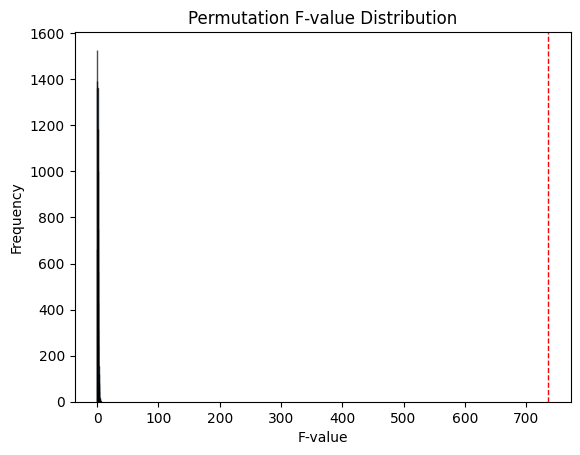

In [45]:
plt.hist(permuted_f_stats, bins=30, edgecolor='k', alpha=0.7)
plt.axvline(observed_f, color='r', linestyle='dashed', linewidth=1)
plt.title('Permutation F-value Distribution')
plt.xlabel('F-value')
plt.ylabel('Frequency')
plt.show()

Because p = 0 < 0.05, we reject the null hypothesis, so the **mean total fines is significantly different** for each category. A strong correlation exists, but we do not have enough evidence to suggest there is a casual relationship in our data.

### Machine Learning

> #### Building a Pipeline Model

In [46]:
# pipeline imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Separate features (X) and target (y)
# Drop CMS because it is an identifier
X = smaller_provider_info.drop(columns=['Overall Rating'])
y = smaller_provider_info['Overall Rating']

# pipeline preprocessing 
categorical = ['State', 'Ownership Type', 'Provider Type', 'Special Focus Status', 'Abuse Icon']
quantitative = ['Number of Certified Beds', 'Average Number of Residents per Day', 'Health Inspection Rating', 'QM Rating',\
                'Staffing Rating', 'Number of Citations from Infection Control Inspections', 'Total Amount of Fines in Dollars']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical),
        ('num', StandardScaler(), quantitative)
    ]
)

# We will use an SVC Model because it can handle complex data and can use special techniques to transform both linear and nonlinear data. 
model = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('classifier', SVC(max_iter=1000, random_state=42))
    ]
)

# train = trains ML algorithm; test = used to evaluate the accuracy of the trained algorithm
# Save 20% of the data for testing
# Split the data into training + test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning:

Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



              precision    recall  f1-score   support

         1.0       0.96      0.99      0.97       678
         2.0       0.95      0.95      0.95       656
         3.0       0.96      0.94      0.95       558
         4.0       0.97      0.93      0.95       511
         5.0       0.97      0.99      0.98       564

    accuracy                           0.96      2967
   macro avg       0.96      0.96      0.96      2967
weighted avg       0.96      0.96      0.96      2967



> #### Results of the Pipeline Model

* **Precision**: Our precision scores range from 0.95-0.97. Out of all the positive predictions we made, 95% to 97% were true.
* **Recall**: Our recall scores range from 0.93-0.99. This means out of all the positive instances, our model correctly predicted 93-99% of them.
* **F1-Score**: This is the harmonic mean of precision and recall. Our F1 scores range from 0.95 to 0.98, which is pretty good! We want to be as close to 1 as possible without overfitting.
* **Support**: A similar number of items appeared in each category, which is what we want.

**Accuracy**: Our model is highly accurate and correctly predicts the outcome **96%** of the time.

- Both the macro and weighted averages are 0.96, 0.96, and 0.96 for precision, recall, and F1 support, respectively.
- Macro averages are the averages where each category (overall ranks 1-5) are weighted equally.
- Weighted averages are the averages where some categories may have special weighting.

> #### Insight & Applications of the Pipeline Model

In [47]:
# Predictions of data that would have an overall quality rating of 1 or 2
# There are 1361 rows (predictions).
predictions = X_test[y_pred<= 2]
predictions.head()

CMS Certification Number (CCN) State  \
2609                          115543    GA   
11558                         425309    SC   
304                           035147    AZ   
4919                          185265    KY   
11039                         395626    PA   

                               Ownership Type  Number of Certified Beds  \
2609                 For profit - Partnership                        74   
11558                For profit - Corporation                        88   
304    For profit - Limited Liability company                        83   
4919                 For profit - Corporation                        95   
11039                Non profit - Corporation                       160   

       Average Number of Residents per Day          Provider Type  \
2609                                  69.0  Medicare and Medicaid   
11558                                 67.2  Medicare and Medicaid   
304                                   56.0  Medicare and Medicaid   
4919                                  78.0  Medicare and Medicaid   
11039                                100.2  Medicare and Medicaid   

      Special Focus Status  Abuse Icon  Health Inspection Rating  QM Rating  \
2609     Not Special Focus           0                       2.0        2.0   
11558    Not Special Focus           0                       1.0        5.0   
304      Not Special Focus           0                       2.0        4.0   
4919     Not Special Focus           0                       3.0        1.0   
11039    Not Special Focus           0                       2.0        3.0   

       Staffing Rating  \
2609               1.0   
11558              1.0   
304                2.0   
4919               4.0   
11039              3.0   

       Number of Citations from Infection Control Inspections  \
2609                                            0.000000        
11558                                           0.000000        
304                                             1.000000        
4919                                            0.000000        
11039                                           0.977124        

       Total Amount of Fines in Dollars  
2609                               0.00  
11558                          41463.88  
304                                0.00  
4919                               0.00  
11039                          15160.60

In [48]:
# This is very close to the number of rows we would expect since our test data is 20% of all the data (1361 rows vs. 1319 expected rows)
true_values = smaller_provider_info[smaller_provider_info['Overall Rating'] <=2]
0.2 * smaller_provider_info.shape[0] * true_values.shape[0]/smaller_provider_info.shape[0]

1319.8000000000002

In [49]:
# 1330 rows in our test predictions actually do have an overall rating of 1 or 2
len([cms for cms in set(predictions['CMS Certification Number (CCN)']) if cms in true_values['CMS Certification Number (CCN)'].values])

1330

In [50]:
# Out of all the predicted instances, about 97.72% had provider IDs (CMS) that matched the true values.
1330/1361*100

97.72226304188098

In [51]:
# 97% of providers that are predicted to have an overall rating of 1 or 2 are Medicare AND Medicaid
predictions['Provider Type'].value_counts(normalize = True)

Provider Type
Medicare and Medicaid    0.972814
Medicare                 0.015430
Medicaid                 0.011756
Name: proportion, dtype: float64

> #### Cost Analysis

In [52]:
predicted_results = pd.DataFrame(
    {
        'CMS Certification Number (CCN)': X_test['CMS Certification Number (CCN)'],
        'Predicted Overall Rating': y_pred
    }
)
predicted_results.set_index('CMS Certification Number (CCN)', inplace=True)
predicted_results.head()

Predicted Overall Rating
CMS Certification Number (CCN)                          
115543                                               1.0
155820                                               3.0
365422                                               3.0
265389                                               5.0
425309                                               2.0

In [53]:
cost_focused_predictions = predicted_results.merge(provider_info[['CMS Certification Number (CCN)', 'Total Amount of Fines in Dollars',\
                                                                  'Number of Fines', 'Number of Payment Denials', 'Total Number of Penalties']],
                                                    on = 'CMS Certification Number (CCN)',
                                                    how = 'left')
cost_focused_predictions.set_index('CMS Certification Number (CCN)', inplace=True)
# Note this dataframe has 2967 rows-- this is because our test data only had 20% of all data (0.2 * smaller_provider_info.shape[0] = 2966.8)

In [54]:
cost_focused_predictions.corr()

Predicted Overall Rating  \
Predicted Overall Rating                          1.000000   
Total Amount of Fines in Dollars                 -0.367246   
Number of Fines                                  -0.289669   
Number of Payment Denials                        -0.298633   
Total Number of Penalties                        -0.320195   

                                  Total Amount of Fines in Dollars  \
Predicted Overall Rating                                 -0.367246   
Total Amount of Fines in Dollars                          1.000000   
Number of Fines                                           0.510367   
Number of Payment Denials                                 0.563067   
Total Number of Penalties                                 0.570487   

                                  Number of Fines  Number of Payment Denials  \
Predicted Overall Rating                -0.289669                  -0.298633   
Total Amount of Fines in Dollars         0.510367                   0.563067   
Number of Fines                          1.000000                   0.340828   
Number of Payment Denials                0.340828                   1.000000   
Total Number of Penalties                0.986885                   0.488118   

                                  Total Number of Penalties  
Predicted Overall Rating                          -0.320195  
Total Amount of Fines in Dollars                   0.570487  
Number of Fines                                    0.986885  
Number of Payment Denials                          0.488118  
Total Number of Penalties                          1.000000

In [55]:
smaller_provider_info.columns

Index(['CMS Certification Number (CCN)', 'State', 'Ownership Type',
       'Number of Certified Beds', 'Average Number of Residents per Day',
       'Provider Type', 'Special Focus Status', 'Abuse Icon', 'Overall Rating',
       'Health Inspection Rating', 'QM Rating', 'Staffing Rating',
       'Number of Citations from Infection Control Inspections',
       'Total Amount of Fines in Dollars'],
      dtype='object')

* There is a **low positive correlation** between predicted overall rating, the total amount of fines, number of payment denials, and total number of penalties
* There is a **moderately strong positive correlation** between the total number of fines in dollars with the number of fines, number of payment denials, and number of penalities. A similar correlation also exists between the number of payment denials and the number of penalties.
* There is a **very strong positive correlation** between number of fines and total number of penalties.
* * This is because the number of fines are included in the calculation for the number of fines.


In [56]:
low_ratings_fines = predictions['Total Amount of Fines in Dollars'].mean()
low_ratings_fines

np.float64(69789.78731814843)

In [57]:
high_ratings_fines = cost_focused_predictions[cost_focused_predictions['Predicted Overall Rating']>= 3]['Total Amount of Fines in Dollars'].mean()
high_ratings_fines

np.float64(13328.976587795765)

In [58]:
low_ratings_fines/high_ratings_fines

np.float64(5.2359449248376)

* The mean total amount of fines PREDICTED for low ratings (1, 2) is over 5 times greater than the mean total amount of fines PREDICTED for high ratings (3-5)
* The model is not predicting that more fines _leads_ to lower ratings, but it suggests **fines are an important indicator** in predicting overall rating

We can quickly confirm there is high ranking have significantly less fines than low rankings with a significance test. Recall that we earlier performed a permutation test to see if there was a significant difference between all ratings (1-5).

**Question of Interest**: Are the mean total amount of fines significantly greater in healthcare providers with lower predicted rankings?


* **H&#8320;:** &mu;&#8321; = &mu;&#8322;, where &mu;&#8321; is the mean total amount of fines for the lower rankings (1-2) and &mu;&#8322; is the mean total amount of fines for the higher rankings (3-5)
* **H&#8321;:** &mu;&#8321; ≥ &mu;&#8322; -> Lower rankings are expected to have more fines.


In [59]:
from scipy.stats import ttest_ind

low_ranking = cost_focused_predictions[cost_focused_predictions['Predicted Overall Rating'] <= 2]['Number of Fines']
high_ranking = cost_focused_predictions[cost_focused_predictions['Predicted Overall Rating'] >= 3]['Number of Fines']
t, p_val = ttest_ind(low_ranking, high_ranking, alternative='greater')

print(f't stat: {t}')
print(f'p value: {p_val}')

t stat: 13.845973826668066
p value: 1.3549086887077013e-42


Since our p-value is 1.35 * 10^(-42) < 0.05, we **reject the null hypothesis**. The total amount of fines is significantly greater in healthcare providers with low predicted rankings.

Now, we will look at payment denials.

In [60]:
cost_focused_predictions[cost_focused_predictions['Predicted Overall Rating'] <= 2]['Number of Payment Denials'].mean()

np.float64(0.39897134459955913)

In [61]:
cost_focused_predictions[cost_focused_predictions['Predicted Overall Rating'] > 2]['Number of Payment Denials'].mean()

np.float64(0.08405977584059776)

At a glance, the mean payment denials for the predicted lower & higher rankings are very similar. We will need to conduct a t-test to investigate whether this difference is significant.

**Question of Interest**: Is the mean number of payment denials significantly greater in healthcare providers with lower predicted rankings?

* **H&#8320;:** &mu;&#8321; = &mu;&#8322;, where &mu;&#8320; is the mean number of payment denials for the lower rankings (1-2) and &mu;&#8323; is the mean number of payment denials for the higher rankings (3-5)
* **H&#8321;:** &mu;&#8321; ≥ &mu;&#8322; -> Lower rankings are expected to have higher payment denials.


In [62]:
low_ranking = cost_focused_predictions[cost_focused_predictions['Predicted Overall Rating'] <= 2]['Number of Payment Denials']
high_ranking = cost_focused_predictions[cost_focused_predictions['Predicted Overall Rating'] >= 3]['Number of Payment Denials']
t, p_val = ttest_ind(low_ranking, high_ranking, alternative='greater')

print(f't stat: {t}')
print(f'p value: {p_val}')

t stat: 14.928237924519427
p value: 6.042596785816663e-49


Since our p-value is 6.04 * 10^(-49) < 0.05, we **reject the null hypothesis**. The number of payment denials is significantly greater in healthcare providers with low predicted rankings.

### Strategy Development

> #### _Problem Analysis_

**Providers** (provide healthcare services; eg hospitals, doctors, clinics, nursing homes) are evaluated on the level of care they provide. They are not impacted directly, but may experience some indirect consequences if they provide poor care. 

There are two crucial types of penalties for nursing homes: **fines** and **payment denials**. 
* **Fines**: Medicare Advantage plans, provided by the health insurance companies, need to pay fines when it is discovered to be non-compliant with regulations from the Centers for Medicare & Medicaid Services (CMS). This is typically associated with the quality of care that _beneficiaries_ (the person enrolled in the Medicare plan) receive. 
* **Payment Denials**: The Medicare plan denies payment to the healthcare provider for a service or medication the beneficiary received if its quality was not satisfactory.

> #### _Ideas for Steps Health Insurance Companies Can Take:_


_#2-5 expand on how to improve quality care._

1. **Better Quality Care**: Fines and payment denials are significant factors that affect the quality of care healthcare services and professionals provide. By focusing on enhanced care, insurance companies will face less fines and payment denials, thus improving the customer's overall experience. In particular, it is vital to consistently achieve high health inspection ratings in order to provide the beneficiaries with optimal service and excellent care. 

2. **Enhanced Staff Training**: Insurance companies could boost the quality of care they provide by enhancing their staff trainings. Staff could be better trained on how to handle situations such as medical emergencies, controlling infections, and meeting safety guidelines and standards. There are two types of important trainings insurance companies could implement: **Patient Care Practices** and **Facility Maintenance**. 

* * **Patient Care Practices**: These would be focused on how to provide premium care to patients, including proper medical procedures, handling medication and relevant medical documents safely, and ensuring the patient has a comfortable experience. It is essential to also practice meeting health standards by maintaining a clean environment, washing hands frequently, and using PPE (personal protective equipment).

* * **Facility Maintenance**: It is also key to maintain a hygienic environment by regularly cleaning and checking facilities, including bathrooms, patient rooms, treatment rooms, etc. It is also important to check all equipment is functional and to keep track of which equipments may be wearing down quickly. Mock inspections could help identify room for improving health inspection ratings.

For both of these practices, health insurance companies should have mandatory video modules for staff training as well as in-person training.

3. **Customer Service**: Health insurance companies could improve the quality of communication they have with their customers. This may mean communicating their message more effectively or decreasing their response time.

4. **Management of Chronic Conditions**: Health insurance companies could have programs that focus on supporting groups with chronic conditions, such as victims of heart and lung diseases. 

5. **Preventative Care**: A healthy customer is a happy customer, so insurance companies could monitor more frequent requirements for screening and tests. Catching diseases and infections early on is improtant before the condition deteriorates. Customers may also watch simple modules online that explain how to prevent and treat non-fatal infections and illnesses. These modules could be shown to them via a personal portal, where the videos shown vary depending on age and relevant risk factors. 

**Note**: While a correlation exists between the following actions and higher ratings, this does not imply causation. However, implementing these steps may increase a health insurance company's likelihood of being perceived favorably.